In [ ]:
!pip install batman-package

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for batman-package: filename=batman_package-2.4.9-cp310-cp310-linux_x86_64.whl size=185099 sha256=e78e18cdf048d915054301fd6cc2044c60f2b65d1b78042719f09270913349c3
  Stored in directory: /root/.cache/pip/wheels/d4/29/f5/245cad7bd7dcb2d11fb9fb1e76a0862145bbaf7731ef9e379e
Successfully built batman-package


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries
import batman
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d
import time


[]
TensorFlow version: 2.15.0


In [ ]:
model_load = load_model("/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/ml_model/april24_2024_model_unfDist_LDC_size_horz_scale.h5")


# 1. Load batman lightcurve

Planet radius (in units of stellar radii) = 0.2
Star to planet ratio = 5.0
LDC = quadratic
LDC = [0.8, 0.0]


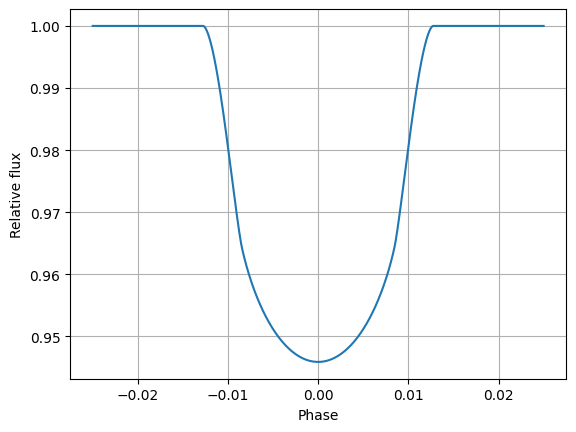

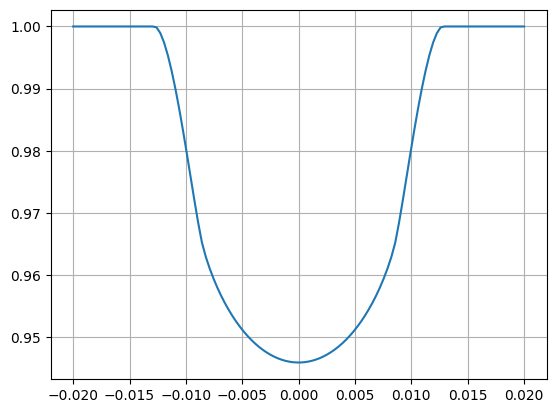

In [ ]:
params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 1/5                      #planet radius (in units of stellar radii)
print(f"Planet radius (in units of stellar radii) = {params.rp}")
print(f"Star to planet ratio = {1/params.rp}")

params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 90.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.8, 0.0]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

print(f"LDC = {params.limb_dark}")
print(f"LDC = {params.u}")

Period = params.per
t = np.linspace(-0.025, 0.025, 1000)
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve

plt.plot(t, flux)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.grid("on")
plt.show()

# Interpolate and save the light curve uniformly spaced from -1 to 1
f = interp1d(t, flux, kind='linear')

new_time = np.linspace(-0.02, 0.02, 120)
new_flux = f(new_time)

plt.plot(new_time, new_flux)
plt.grid("on")
plt.show()

In [ ]:
lc_name = f"BATMAN_startoplanet{int(1/params.rp)}_a{params.u[0]}_b{params.u[1]}.npy"
print(lc_name)

BATMAN_startoplanet5_a0.8_b0.0.npy


In [ ]:
lc_dir = '/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/BATMAN_LIGHTCURVE/'
lc_name = f"BATMAN_startoplanet{int(1/params.rp)}_a{params.u[0]}_b{params.u[1]}.npy"
print("Path to save LC:\n", lc_dir+lc_name)
np.save(lc_dir+lc_name, new_flux)


Path to save LC:
 /content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/BATMAN_LIGHTCURVE/BATMAN_startoplanet5_a0.8_b0.0.npy


# 2. Predict the shape


In [ ]:
test_lc = np.load(lc_dir+lc_name)
print("test_lc.shape = ", test_lc.shape)

test_lc = np.reshape(test_lc, newshape=(1, 120))
print("test_lc.shape = ", test_lc.shape)

# Don't run if data is already normalized
# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

test_lc.shape =  (120,)
test_lc.shape =  (1, 120)


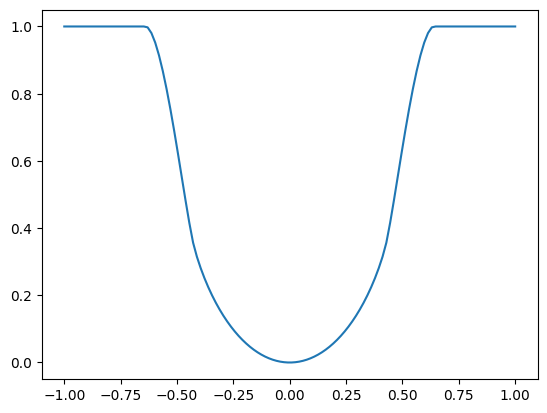

In [ ]:
plt.plot(np.linspace(-1,1,len(test_lc_scaled[0])), test_lc_scaled[0])
plt.show()

In [ ]:
# Append with ones (if required only.
# eg APPENING not required for BATMAN lightcurve since we already append BATMAN
# while saving it as csv file and npy file)
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],150))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,15:135] = test_lc_scaled[i]
print("Extended the light curves")

# del test_lc
# del test_lc_scaled

Extended the light curves


In [ ]:
# 5. Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros

    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        print("left_index =", left_index)
        print("right_index =", right_index)
        print("Length =", right_index-left_index+1)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='linear')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)

        # # Replacing end elements with 1

        # y_interpolated[0:9] = np.ones(len(y_interpolated[0:9]))
        # # print(f"len(y_interpolated[0:9])) = {len(y_interpolated[0:9])}")

        # y_interpolated[111:120] = np.ones(len(y_interpolated[111:120]))
        # # print(f"len(y_interpolated[111:120])) = {len(y_interpolated[111:120])}")

        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
# del test_lc_scaled_append

processed_test_lc = test_lc_horiz_scaled
# del test_lc_horiz_scaled


Length of one LC =  150
input_lc_dataset_interpol.shape = (1, 120)
center_index = 75
left_index = 27
right_index = 123
Length = 97


In [ ]:
# Test on the ML model - Test Dataset - Original Simulated light curve
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
# processed_test_lc = np.zeros(shape=(1,120))
test_predict_shape = model_load.predict(processed_test_lc) # model_load.predict(test_lc_scaled) #
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

1/1 [==============================] - 0s 23ms/step
Normalized the predicted shape


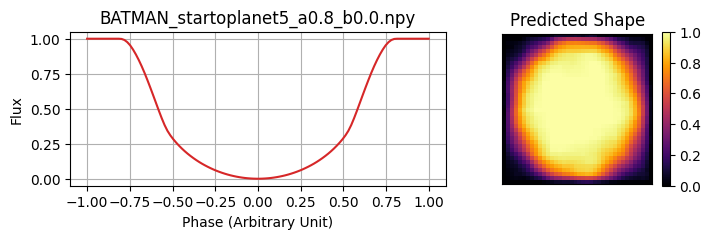

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,2),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title(lc_name)
axes[0].plot(ph, processed_test_lc[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()


# 3. To predict shapes from multiple BATMAN light curve use this function

In [ ]:
def predict_batman_lc(a, b, star2planet_radius_ratio, ml_model_link, SNR=None):
    params = batman.TransitParams()
    params.t0 = 0.                       #time of inferior conjunction
    params.per = 1.                      #orbital period
    params.rp = 1/star2planet_radius_ratio            #planet radius (in units of stellar radii)
    # print(f"Planet radius (in units of stellar radii) = {params.rp}")
    # print(f"Star to planet ratio = {1/params.rp}")

    params.a = 15.                       #semi-major axis (in units of stellar radii) default 15
    params.inc = 90.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [a, b]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model

    # print(f"LDC = {params.limb_dark}")
    # print(f"LDC = {params.u}")

    Period = params.per
    t = np.linspace(-0.025, 0.025, 1000)
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve

    # plt.plot(t, flux)
    # plt.xlabel("Phase")
    # plt.ylabel("Relative flux")
    # plt.grid("on")
    # plt.show()

    # Interpolate and save the light curve uniformly spaced from -1 to 1
    f = interp1d(t, flux, kind='linear')

    new_time = np.linspace(-0.02, 0.02, 120)
    new_flux = f(new_time)
    lc_name = f"BATMAN_startoplanet{int(1/params.rp)}_a{params.u[0]}_b{params.u[1]}.npy"
    np.save(lc_name, new_flux)

    test_lc = np.load(lc_name)
    test_lc = np.reshape(test_lc, newshape=(1, 120))

    # Don't run if data is already normalized
    # Normalize the lightcurves
    ## - Test Set
    test_lc_scaled = np.zeros(test_lc.shape)
    for i in np.arange(len(test_lc_scaled)):
        test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))
    # Append with ones
    test_lc_scaled_append = np.ones((test_lc.shape[0],150))
    for i in np.arange(len(test_lc_scaled)):
        test_lc_scaled_append[i,15:135] = test_lc_scaled[i]

    def scale_horizontally(input_lc_dataset):
        # lc_np_array_offset_mask used to select the flat part by certain percentage
        input_lc_dataset_mask = np.copy(input_lc_dataset)

        for iteration in np.arange(len(input_lc_dataset)):
            # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
            input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
            input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

        count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
        for iteration in np.arange(len(input_lc_dataset_mask)):
            # Calculate the number of occurrences of '0'
            count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
            count_zeros_array[iteration] = count_zeros

        # Interpolate the light curve
        input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
        len_selected_portion = np.zeros(len(input_lc_dataset))

        center_index = int(len(input_lc_dataset[0])/2)

        for iteration in np.arange(len(input_lc_dataset_interpol)):

            left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
            right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
            selected_portion = input_lc_dataset[iteration][left_index:right_index]


            # Calculate the length of the selected region
            len_selected_portion[iteration] = len(selected_portion)

            # Interpolate the selected portion
            # Original data
            original_x = np.linspace(-1, 1, num=len(selected_portion))
            original_y = selected_portion

            # Create a quadratic interpolation function
            f = interp1d(original_x, original_y, kind='linear')

            # Define the range of x-values for the interpolation with 120 elements
            x_interpolation = np.linspace(-1, 1, num=120)

            # Perform the interpolation
            y_interpolated = f(x_interpolation)

            input_lc_dataset_interpol[iteration] = y_interpolated

        return input_lc_dataset_interpol

    test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
    def add_noise(test_lc_scaled_append, SNR):
        std_dev = 1/SNR
        test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)
        rng = np.random.default_rng()

        for i in np.arange(len(test_lc_scaled_append)):
            noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(test_lc_scaled_append[i]))
            rng.shuffle(noise_temp)
            test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp
        return test_lc_scaled_append_noise

    if SNR == None:
        processed_test_lc = test_lc_horiz_scaled
    else:
        processed_test_lc = add_noise(test_lc_horiz_scaled, SNR)


    model_load = load_model(ml_model_link)
    # Test on the ML model - Test Dataset - Original Simulated light curve
    # (i.e. without sampling and interpolation)
    # Test dataset - Prediciton
    # processed_test_lc = np.zeros(shape=(1,120))
    test_predict_shape = model_load.predict(processed_test_lc) # model_load.predict(test_lc_scaled) #
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")
    test_predict_shape = test_predict_shape_normalized
    del test_predict_shape_normalized
    return (test_predict_shape[0], processed_test_lc[0], a, b, star2planet_radius_ratio, SNR)



In [ ]:
model_path = "/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/ml_model/april24_2024_model_unfDist_LDC_size_horz_scale.h5"

predict_shape, lc, a, b, star2planet_radius_ratio = predict_batman_lc(
    a=0.5,
    b=0.5,
    star2planet_radius_ratio=5,
    ml_model_link=model_path)

1/1 [==============================] - 0s 229ms/step
Normalized the predicted shape


1/1 [==============================] - 0s 262ms/step
Normalized the predicted shape
1/1 [==============================] - 0s 252ms/step
Normalized the predicted shape
1/1 [==============================] - 0s 371ms/step
Normalized the predicted shape
1/1 [==============================] - 0s 391ms/step
Normalized the predicted shape


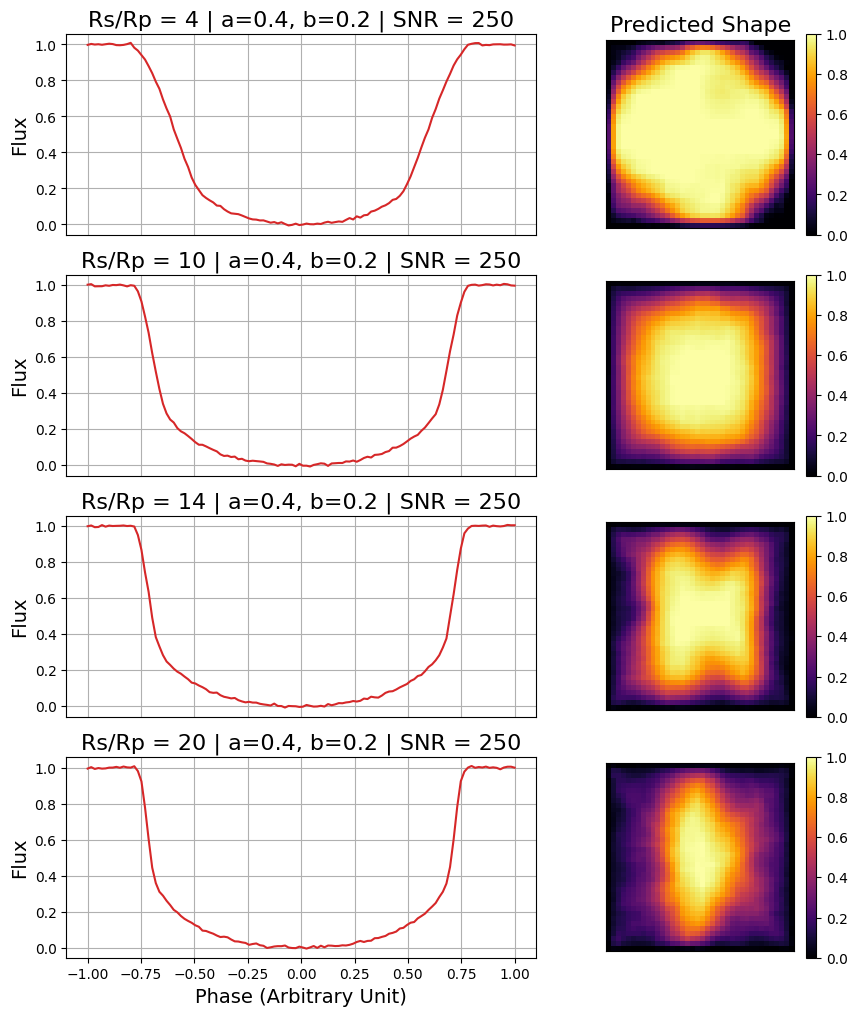

In [ ]:
model_path = "/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/ml_model/april24_2024_model_unfDist_LDC_size_horz_scale.h5"
num_row = 4
fig, axes = plt.subplots(num_row, 2, figsize=(10,12),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns


# Plot on each subplot
a_array = [0.4, 0.4, 0.4, 0.4]
b_array = [0.2, 0.2, 0.2, 0.2]
SNR = [250, 250, 250, 250]
# [125, 100, 75, 50] # [500, 250, 175, 150]
star2planet_radius_ratio__array = [4, 10, 14, 20]
for i in np.arange(num_row):
    predict_shape, lc, a, b, star2planet_radius_ratio, SNR_ret = predict_batman_lc(
    a=a_array[i],
    b=b_array[i],
    star2planet_radius_ratio=star2planet_radius_ratio__array[i],
    ml_model_link=model_path,
    SNR = SNR[i]
)
    ph = np.linspace(-1,1,len(lc))
    if SNR_ret==None:
        axes[i][1].set_title(f'Rs/Rp = {star2planet_radius_ratio} | a={a}, b={b}', fontsize=16)
    else:
        axes[i][0].set_title(f"Rs/Rp = {star2planet_radius_ratio} | a={a}, b={b} | SNR = {SNR_ret}", fontsize=16)


    axes[i][0].plot(ph, lc, color='tab:red')
    axes[i][0].grid('on')
    axes[i][0].set_ylabel('Flux', fontsize=14)

    if i != num_row - 1:
        axes[i][0].tick_params(labelbottom = False, bottom = False)  # Remove x ticks except for the last row

    axes[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = axes[i][1].imshow(predict_shape,cmap='inferno')
    plt.colorbar(img)


axes[0][1].set_title('Predicted Shape', fontsize=16)

axes[num_row-1][0].set_xlabel('Phase (Arbitrary Unit)', fontsize=14)
plt.show()
